# Comparison of Different Optimizers for QAOA on a Max Cut instance
In this notebook different optimizers for the QAOA parameters are compared. The approximation ratios obtained by using the different optimizers are compared, as well as the value of the QAOA parameters. 

In [1]:
from qaoa import QAOA, problems, mixers, initialstates

In [2]:
import numpy as np
import networkx as nx
import sys                     
sys.path.append('../')         
from plotroutines import *

from qiskit_algorithms.optimizers import SPSA, QNSPSA, COBYLA, NELDER_MEAD

Create Barabási–Albert graph instance, more examples can be found here https://github.com/OpenQuantumComputing/data

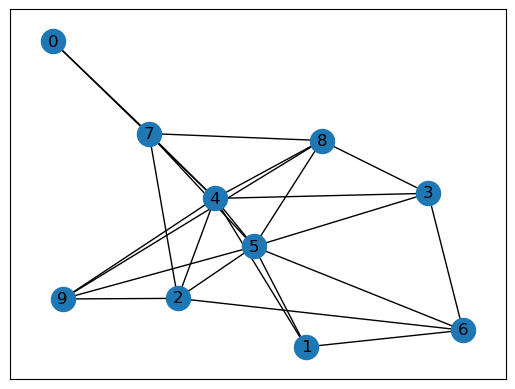

In [3]:
G = nx.read_gml("data/w_ba_n10_k4_0.gml")
nx.draw_networkx(G)
mincost = -8.657714089848158 # precalculated

Setting up the optimizers to use roughly the same number of function evaluations

In [4]:
optimizers = {}
plotstyle = {}

settings = {
    "maxiter": 70,
    "blocking": True,
    "allowed_increase": 0,
    "second_order": True,
    "regularization": 0.01,
}
optimizers["spsa"] = [SPSA, settings.copy()]
plotstyle["spsa"] = "+-"

settings = {
    "maxiter": 50,
    "blocking": True,
    "allowed_increase": 0,
    "learning_rate": 0.02,
    "perturbation": 0.05,
    "regularization": 0.01,
    "hessian_delay": 0,
}
optimizers["qnspsa"] = [QNSPSA, settings.copy()]
plotstyle["qnspsa"] = "o-"

settings = {"maxiter": 110, "tol": 1e-6}
optimizers["neldermead"] = [NELDER_MEAD, settings.copy()]
plotstyle["neldermead"] = "x-"

settings = {"maxiter": 350, "tol": 1e-6}
optimizers["cobyla"] = [COBYLA, settings.copy()]
plotstyle["cobyla"] = "*-"

Create a QAOA instance for each optimizer

In [5]:
qaoa = {}
for key in optimizers:
    qaoa[key] = QAOA(
        initialstate=initialstates.Plus(),
        problem=problems.MaxCut(G=G),
        mixer=mixers.X(),
        optimizer=optimizers[key],
    )

run optimization to maxdepth

In [6]:
maxdepth = 10
for key in optimizers:
    qaoa[key].optimize(depth=maxdepth)

2023-09-22 21:52:10 [info     ] Calculating energy landscape for depth p=1... file=qaoa.qaoa func=sample_cost_landscape
1 0
2023-09-22 21:52:10 [info     ] Executing sample_cost_landscape file=qaoa.qaoa func=sample_cost_landscape
2023-09-22 21:52:10 [info     ] parameters: 2                  file=qaoa.qaoa func=sample_cost_landscape
2023-09-22 21:52:10 [info     ] Done execute                   file=qaoa.qaoa func=sample_cost_landscape
2023-09-22 21:52:18 [info     ] Done measurement               file=qaoa.qaoa func=sample_cost_landscape
2023-09-22 21:52:18 [info     ] Calculating Energy landscape done file=qaoa.qaoa func=sample_cost_landscape
2023-09-22 21:52:39 [info     ] cost(depth 1 = -6.862537686473127 file=qaoa.qaoa func=optimize
2023-09-22 21:53:07 [info     ] cost(depth 2 = -7.307199031780441 file=qaoa.qaoa func=optimize
2023-09-22 21:53:42 [info     ] cost(depth 3 = -7.7215808561463675 file=qaoa.qaoa func=optimize
2023-09-22 21:54:21 [info     ] cost(depth 4 = -7.86662827237

Below the approximation ratios are plotted for the different optimizers. From the figure we see that the different optimizers give roughly the same approximation ratio.

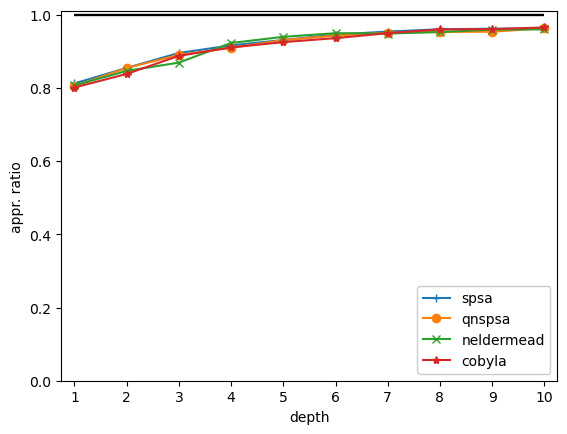

In [7]:
fig=pl.figure()
for key in optimizers:
    plot_Exp(qaoa[key], maxdepth, mincost=mincost, maxcost=0, label=key, style=plotstyle[key],fig=fig)

Below we plot the values for $\gamma$ and $\beta$ parameters found by the different optimizers. The values found are seen to be relatively similar for all the optimizers. Importantly, the value for $\gamma$ is seen to be increasing with depth and the value of $\beta$ is seen to be decreasing with depth, in accordance with the heuristic strategy used to find the values for the parameters for increasing depth (see Quantum Approximate Optimization Algorithm: Performance, Mechanism, and Implementation on Near-Term Devices by Zhou et al.)

[0.40860924 0.44662212 0.5839692  0.36138466 0.63581948 0.33889878
 0.68466665 0.300936   0.75739029 0.28106842 0.84049993 0.2649458
 0.91853284 0.23014153 0.993445   0.1846138  1.07266798 0.14024762
 1.10532425 0.09536158]
[0.41013098 0.51950193 0.56919236 0.37706649 0.63127037 0.34976473
 0.73348903 0.28828595 0.76042561 0.26935856 0.78287308 0.23633504
 0.8235239  0.21793913 0.82198435 0.17087569 0.88110942 0.16222973
 0.94480343 0.09850973]
[0.63691221 2.11865158 0.86094688 2.03152988 0.98733643 1.94349752
 1.07564157 1.96279403 1.13517726 1.91796304 1.17854536 1.89181058
 1.23909572 1.81920731 1.27758355 1.75835    1.32534162 1.69483063
 1.30186684 1.63393322]
[0.42365825 0.44987916 0.64050348 0.35917468 0.75161952 0.29143322
 0.81575032 0.25144916 0.84713562 0.21964986 0.85255997 0.19678253
 0.81266889 0.12553162 0.83704658 0.09945801 0.8522464  0.05638954
 1.90499661 0.03104779]


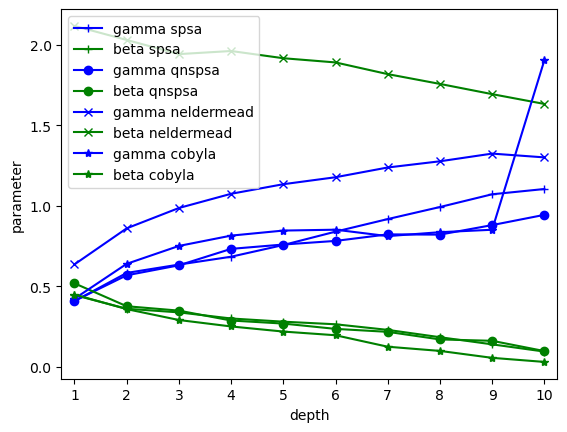

In [8]:
ax = pl.figure().gca()
for key in optimizers:
    angles=qaoa[key].optimization_results[maxdepth].get_best_angles()
    print(angles)
    pl.plot(
        np.arange(1, maxdepth + 1),
        angles[::2],
        "b" + plotstyle[key],
        label="gamma " + key,
    )
    pl.plot(
        np.arange(1, maxdepth + 1),
        angles[1::2],
        "g" + plotstyle[key],
        label="beta " + key,
    )
pl.xlim(1 - 0.25, maxdepth + 0.25)
_ = pl.ylabel("parameter")
_ = pl.xlabel("depth")
_ = pl.legend()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

Below the number of function evaluations used by the different optimizers are plotted for increasing depths. 

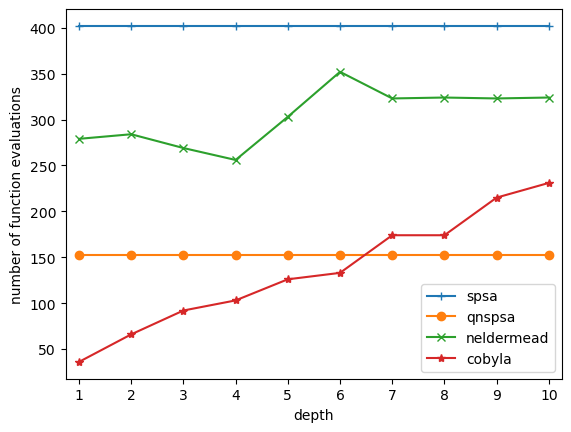

In [9]:
ax = pl.figure().gca()
for key in optimizers:
    tmp=[]
    for i in range(maxdepth):
        tmp.append(qaoa[key].optimization_results[i+1].num_fval())
    _ = pl.plot(
        np.arange(1, maxdepth + 1),
        tmp,
        plotstyle[key],
        label=key,
    )
pl.xlim(1 - 0.25, maxdepth + 0.25)
_ = pl.ylabel("number of function evaluations")
_ = pl.xlabel("depth")
_ = pl.legend()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))